In [1]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.manual_seed(0)
np.random.seed(0)

c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
#  configurations - HYPER PARAMETERS
################################################################
epochs = 20
batch_size = 10
learning_rate = 0.001

epochs = 100
step_size = 50
gamma = 0.5

width = 64

weight_decay=1e-4

# Hyperparameters to change - epoch{10,100,200}, step_size{}, batchsize{}, gamma{}, modes{}, weight_decay{}

In [3]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        #print('input',input.shape)
        #print('weights',weights.shape)
        #print("bixy,ioxy->boxy")
        R = input * 
        R_out = torch.einsum("bixy,ioxy->boxy", input, weights)
        #print(R_out.shape)
        return R_out

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        #print('what is out_ft', out_ft.shape)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [4]:
class FCN_sigma(nn.Module):
    def __init__(self):
        super(FCN_sigma, self).__init__()
       
        self.fc0 = nn.Linear(128, 500)
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 256)

    def forward(self, x):
       
        x = self.fc0(x)
        x = F.relu(x)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)        
        x = F.sigmoid(x)
        return x


class FCN_linear(nn.Module):
    def __init__(self):
        super(FCN_linear, self).__init__()
       
        self.fc0 = nn.Linear(128, 500)
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 256)

    def forward(self, x):
       
        x = self.fc0(x)
        x = F.relu(x)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)        
        #x = F.sigmoid(x)
        return x



class FCN_fft(nn.Module):
    def __init__(self):
        super(FCN_fft, self).__init__()
       
        self.fc0 = nn.Linear(128, 500)
        self.fc1 = nn.Linear(500, 256)

    def forward(self, x):
       
        x = self.fc0(x)
        x = F.relu(x)

        x = torch.fft.fft(x)
        x = F.relu(x)

        x = self.fc1(x)

        x = torch.fft.ifft(x)
        #x = F.softmax(x)
        return x

In [5]:
# DATA LOADING
############################## DATA LOADING ########################################
raw_data = scipy.io.loadmat('./datasets/training_data_16x16_10k')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['measurement_data'])


def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes, sol)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#y_normalizer = UnitGaussianNormalizer(y_train)
#y_train = y_normalizer.encode(y_train)

#x_normalizer = UnitGaussianNormalizer(X_train)
#X_train = x_normalizer.encode(X_train)
#X_test = x_normalizer.encode(X_test)


#batch_size = 10
#train_loader = DataLoader(data_utils.TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]

print('training: measurement', X_train.shape, 'solution', y_train.shape)
print('test: measurement', X_test.shape, 'solution', y_test.shape)

training: measurement torch.Size([8000, 128]) solution torch.Size([8000, 256])
test: measurement torch.Size([2000, 128]) solution torch.Size([2000, 256])


In [6]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
        model.eval()
        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", model_rms, std_rms, sep="---")
    print("PSNR: ", model_psnr, std_psnr, sep="---")
    print("SSIM: ", model_ssim, std_ssim, sep="---")
    print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    }
    return output 

In [7]:
# TRAINING AND EVALUATION
################################################################
# TRAINING AND EVALUATION
################################################################


def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)

        print(ep, t2 - t1, train_l2, test_l2)
    total_time = sum(epoch_time)
    print("TOTAL TIME: ", total_time, sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": total_time,
    "model": model
    }
    return output 

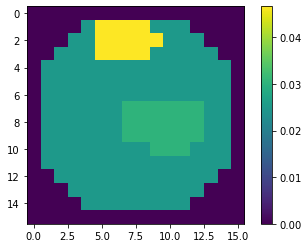

In [8]:
#Actual
test_num = 12
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

In [9]:
test_loader.dataset[test_num][0].shape 

torch.Size([128])

443256
0 3.663070599985076 0.375350525021553 0.17539288103580475
1 2.0784077999996953 0.17438955990970134 0.16551963317394255
2 1.965764599997783 0.17056545202434062 0.16593902385234832
3 1.9400285000156146 0.21216149847954513 0.2534390119314194
4 2.042803299991647 0.2519869584441185 0.2505291268229485
5 2.1846354999870528 0.25178537729382516 0.2507814475893974
6 2.0514528999920003 0.2517391539365053 0.25007509177923204
7 2.0224118000187445 0.26055302408337594 0.2511222447156906
8 2.0687572000024375 0.25243633522093295 0.2503210940361023
9 1.9815152999944985 0.26299028846621514 0.25122335797548295
10 2.0372759999881964 0.25213518388569356 0.2508645003437996
11 1.9962281000043731 0.26278816516697406 0.24948997163772582
12 1.9741608999902382 0.2584693214893341 0.25001989394426344
13 2.059902599983616 0.2617883586883545 0.25117367869615553
14 2.033669299999019 0.25388696628808977 0.25108804655075073
15 1.9899855999974534 0.2521164919286966 0.2496109539270401
16 2.0006144999933895 0.252564

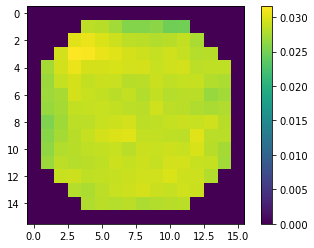

In [10]:
# LINEAR - TEST NETWORK
############################################################################

model_fcn_linear = FCN_linear().cuda()
print(count_params(model_fcn_linear))
output_linear = train_model(model_fcn_linear, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_linear_model = output_linear.get("model")
#torch.save(output_1L_model, 'fno2D_1l.h5')
results_linear = model_metrics(output_linear_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_linear_model.eval()
predicted = np.reshape(output_linear_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

443256


c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 2.1493415999866556 1.0508333773612977 1.0
1 2.0711089999822434 1.0 1.0
2 2.032570100011071 1.0 1.0
3 2.0900551000086125 1.001867092013359 1.0
4 2.063179599994328 1.0034786294698714 1.0
5 2.0401031000074 1.0 1.0
6 2.0815867999917828 1.0 1.0
7 2.09161099998164 2.4643681534528734 2.5880558776855467
8 2.059124699997483 3.3234028878211976 4.249487726211548
9 2.0810590000182856 4.355108847618103 4.872767776489257
10 2.0391047000011895 5.912974184036255 7.969090118408203
11 2.023505599994678 8.555493599891662 10.714108612060548
12 2.0236343999858946 10.884788287162781 11.232821029663086
13 2.057413800008362 12.55922963142395 13.53116952896118
14 2.0560961999872234 12.71884102666378 1.0
15 2.042872400023043 1.0 1.0
16 2.033167100016726 1.0 1.0
17 2.0360459000221454 1.0000000011920929 1.0000000066757202
18 2.11814570002025 1.000000011920929 1.0000000095367432
19 2.054265199985821 1.0000000154972077 1.0000000166893006
TOTAL TIME: ---41.243991000024835
RMSE: ---0.026014363602883207---0.00418890

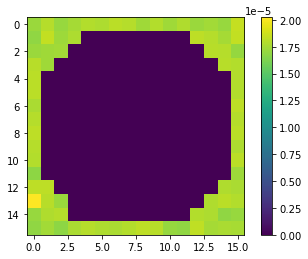

In [11]:
# SIGMA - TEST NETWORK
############################################################################

model_fcn_sigma = FCN_sigma().cuda()
print(count_params(model_fcn_sigma))
output_sigma = train_model(model_fcn_sigma, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_sigma_model = output_sigma.get("model")
#torch.save(output_1L_model, 'fno2D_1l.h5')
results_sigma = model_metrics(output_sigma_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_sigma_model.eval()
predicted = np.reshape(output_sigma_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

In [12]:
''' 
# SOFTMAX - TEST NETWORK
############################################################################

model_softmax = FCN_softmax().cuda()
print(count_params(model_softmax))
output_softmax = train_model(model_softmax, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_softmax_model = output_softmax.get("model")
#torch.save(output_1L_model, 'fno2D_1l.h5')
results_softmax = model_metrics(output_softmax_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_softmax_model.eval()
predicted = np.reshape(output_softmax_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()
'''

' \n# SOFTMAX - TEST NETWORK\n############################################################################\n\nmodel_softmax = FCN_softmax().cuda()\nprint(count_params(model_softmax))\noutput_softmax = train_model(model_softmax, 20, batch_size, learning_rate, weight_decay, step_size, gamma)\n\noutput_softmax_model = output_softmax.get("model")\n#torch.save(output_1L_model, \'fno2D_1l.h5\')\nresults_softmax = model_metrics(output_softmax_model,test_loader,ntrain)\n\n# TEST NETWORK RESULTS\n############################################################################\nK = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()\noutput_softmax_model.eval()\npredicted = np.reshape(output_softmax_model(K).detach().cpu().numpy(),(16,16))\nplt.imshow(predicted)\nplt.colorbar()\n'

In [13]:
#plt.plot(output_1L.get('train_losses')[5:20], label='1 fourier layer')
plt.plot(range(5,20),output_1L.get('train_losses')[5:20], label='2 fourier layers')
#plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend(frameon=False)

NameError: name 'output_1L' is not defined

# TEST FOR FNO

In [ ]:
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        #print('input',input.shape)
        #print('weights',weights.shape)
        #print("bixy,ioxy->boxy")
        R_out = torch.einsum("bixy,ioxy->boxy", input, weights)
        #print(R_out.shape)
        return R_out

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        #print('what is out_ft', out_ft.shape)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [17]:
input = torch.rand(3,5,5)
output = torch.rand(3,3,3)

In [23]:
# multiplication stage

W = torch.rand(input.shape[0],input.shape[1], output.shape[2], dtype=torch.cfloat)
W

tensor([[[0.3633+0.3733j, 0.2683+0.7024j, 0.6228+0.6506j],
         [0.4585+0.0264j, 0.3322+0.3966j, 0.7774+0.2647j],
         [0.2938+0.4719j, 0.0418+0.4427j, 0.3114+0.1703j],
         [0.7981+0.7370j, 0.9117+0.7710j, 0.2618+0.1473j],
         [0.4337+0.0801j, 0.1319+0.0243j, 0.6665+0.4961j]],

        [[0.2008+0.5773j, 0.1252+0.6824j, 0.5846+0.8184j],
         [0.4011+0.4663j, 0.7565+0.3775j, 0.0996+0.9610j],
         [0.1531+0.1047j, 0.6153+0.5607j, 0.3336+0.9903j],
         [0.6151+0.6078j, 0.4015+0.2314j, 0.7674+0.1237j],
         [0.6829+0.9344j, 0.7748+0.1116j, 0.5314+0.4760j]],

        [[0.5629+0.7232j, 0.8935+0.6686j, 0.7484+0.7616j],
         [0.7838+0.7649j, 0.1858+0.9662j, 0.7588+0.2966j],
         [0.4402+0.5359j, 0.6487+0.2216j, 0.2683+0.7334j],
         [0.7362+0.7255j, 0.3129+0.7232j, 0.6550+0.8490j],
         [0.3060+0.8729j, 0.8617+0.4146j, 0.2986+0.5970j]]])

In [ ]:
    def forward(self, input_data):
        batchsize = input_data.shape[0]
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias


In [41]:
class Fourier(nn.Module):
    def __init__(self, input_dim, output_dim):
    # input_dim = number of input neurons
    # output_dim = number of output neurons
        super(Fourier, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.scale = (1 / (input_dim * output_dim))

        self.weights = nn.Parameter(self.scale * torch.rand(input_dim, output_dim, dtype=torch.cfloat))


        def __init__(self, input_size, output_size):
            self.weights = torch.rand(input_size, output_size, dtype=torch.cfloat)
            #self.bias = torch.rand(1, output_size, dtype=torch.cfloat)
            #self.W = self.weights + self.bias

        # returns output for a given input
        def forward(self, x):
            x_fft = torch.fft.rfft2(x) 
            
            R_weight = torch.einsum('ijk,ijl->ijl',x_fft, self.weights)

            x = torch.fft.irfft2(R_weight)
            return x 


In [52]:
conv_f = Fourier(5, 8)

In [54]:
conv_f(input2)

NotImplementedError: 

In [51]:
input2 = torch.rand(5,5)
input2

tensor([[0.6131, 0.8707, 0.4915, 0.6130, 0.8611],
        [0.6053, 0.9448, 0.4017, 0.0042, 0.6914],
        [0.6780, 0.2428, 0.0091, 0.9658, 0.7889],
        [0.9339, 0.3173, 0.1919, 0.4716, 0.9922],
        [0.2779, 0.7032, 0.9692, 0.5107, 0.8150]])

In [28]:
W = torch.rand(input.shape[0],input.shape[1], output.shape[2], dtype=torch.cfloat)


In [40]:
complex_weights = torch.einsum('ijk,ijl->ijl',input,W)

In [38]:
W.shape

torch.Size([3, 5, 3])

In [66]:
temp_data = scipy.io.loadmat('./datasets/mes_example')


In [75]:
mes_im = temp_data['im']
mes_re = temp_data['re']

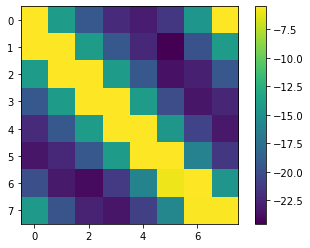

In [94]:
im_dense = mes_im.todense()
plt.imshow(im_dense.reshape(8,8))
plt.colorbar()

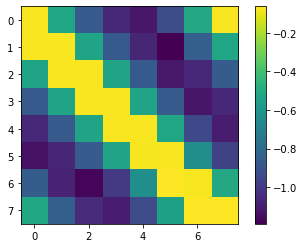

In [95]:
re_dense = mes_re.todense()
plt.imshow(re_dense.reshape(8,8))
plt.colorbar()